# PID Tuning Analysis

This notebook analyzes the PID tuning data from Arduino Tune_v2 recordings.
It analyzes baseline, step sweeps, overlays, and manual protocols.


## Import Libraries


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import h5py
import os
from scipy.signal import butter, filtfilt
from scipy import ndimage
import mat73
import neurodap as ndap


ModuleNotFoundError: No module named 'neurodap'

## Helper Functions


In [ ]:
def butter_lowpass_filter(data, cutoff, fs, order=4):
    """Low-pass Butterworth filter"""
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def moving_zscore(data, window_size):
    """Calculate moving z-score"""
    moving_mean = ndimage.uniform_filter1d(data, size=window_size, mode='constant')
    moving_var = ndimage.uniform_filter1d(data**2, size=window_size, mode='constant') - moving_mean**2
    moving_std = np.sqrt(np.maximum(moving_var, 1e-8))
    return (data - moving_mean) / moving_std


In [22]:
import matplotlib.colors as mcolors

def plot_sem(y, x=None, 
            label=None, color=None, ax=None, alpha=None, 
            fill=True,
            plot_individual=False):

    n_events, n_timepoints = y.shape

    if x is None:
        x = np.arange(n_timepoints)
    
    if ax is None:
        ax = plt.gca()
    if color is None:
        color = ax._get_lines.get_next_color()

    # Make color more transparent based on alpha values
    # If color is a string or tuple, convert to RGBA and apply alpha if given
    if alpha is not None:
        try:
            base_color = mcolors.to_rgba(color)
            color = (base_color[0], base_color[1], base_color[2], alpha)
        except Exception:
            # fallback: if color cannot be converted, just use as is
            pass

    norm = mcolors.Normalize(vmin=0, vmax=len(y))

    mean = np.nanmean(y, axis=0)
    sem  = np.nanstd(y, axis=0, ddof=1) / np.sqrt(np.sum(~np.isnan(y), axis=0))
    ax.plot(x, mean, color=color, label=label)
    
    if fill: ax.fill_between(x, mean - sem, mean + sem, alpha=0.2, color=color, edgecolor='None', label="_nolegend_")

    if plot_individual:
        for i, trace in enumerate(y):
            ax.plot(x, trace, linewidth=0.5, color=color, alpha=0.2, label="_nolegend_")

In [23]:
def get_traces(data, event, pre_steps, post_steps):
    data = np.asarray(data)
    T    = data.shape[0]

    if len(data) == len(event):
        event_idx = np.where(np.diff(event) == 1)[0] + 1
    else:
        event_idx = np.asarray(event, dtype=int)

    n_trials   = len(event_idx)
    window_len = pre_steps + post_steps + 1

    aligned_data = np.zeros((n_trials, window_len), dtype=data.dtype)

    for i, idx in enumerate(event_idx):
        start = idx - pre_steps
        end   = idx + post_steps
        data_lo = max(start, 0)
        data_hi = min(end, T - 1)
        win_start = data_lo - start  # Offset in window if event too close to data edge
        win_end = win_start + (data_hi - data_lo) + 1
        aligned_data[i, win_start : win_end] = data[data_lo : data_hi + 1]

    return aligned_data

## Load Data and Calculate PWM from Laser Signals


In [ ]:
# Load data (adjust path as needed)
session_name = 'YOUR_SESSION_NAME_g0'
root_dir = '/path/to/your/recordings/'
data_file_path = os.path.join(root_dir, f'{session_name}', f'data_{session_name}.mat')

# Load the MATLAB file
data_mat = mat73.loadmat(data_file_path)

# Extract raw signals
red_laser_raw = data_mat['redClamp'].flatten()  # Inhibit channel
blue_laser_raw = data_mat['blueClamp'].flatten()  # Excite channel
dopamine_raw = data_mat['photometry_raw'].flatten()

print(f"Data loaded: {len(dopamine_raw)} samples")


In [ ]:
# Preprocess data
Fs = 10000  # Original sampling frequency in Hz
cutoff = 200  # Cutoff frequency in Hz
dopamine_filtered = butter_lowpass_filter(dopamine_raw.flatten(), cutoff, Fs)

# Moving z-score
window_size = Fs * 60  # 60 seconds
dopamine_zscore = moving_zscore(dopamine_filtered, window_size)

# Downsample (optional)
targetFs = 10000
downsample_factor = int(Fs/targetFs)
red_laser = red_laser_raw[::downsample_factor]
blue_laser = blue_laser_raw[::downsample_factor]
dopamine = dopamine_zscore[::downsample_factor]

print(f"Data shape: {dopamine.shape}")
print(f"Sampling rate: {targetFs} Hz")


## 1. Calculate PWM from Duty Cycle

The laser signals are binary (0/1). We calculate the duty cycle of each pulse and convert it to PWM values (0-255).


In [1]:
def extract_stim_pwm(
    clamp_trace,
    *,
    fs=10_000,
    duration=[2.0, 3.0, 9.0],                # e.g., [0.1, 0.5, 1.0] to snap
    inter_stim_min_s=3.0,
    low_pct=0.1,
    high_pct=99.99999999999999,
    pwm_resolution_bits=8,        # 8-bit → 0..255
    pwm=None                      # e.g., [20, 30, 40] to snap to known counts
):
    """
    Segment PWM stims by rising edges (> inter_stim_min_s gap), then compute duty from RAW analog.

    Returns:
        List[Tuple[int, int, float, int, float]]:
            (onset_sample, end_sample, duration_s, pwm_counts, duty_frac)

    Notes:
        - Sample indices are 0-based.
        - duty_frac is in [0, 1].
        - pwm_counts is snapped to `pwm` if provided.
        - If `duration` is provided, durations are snapped and end_sample is adjusted accordingly.
    """
    x = np.asarray(clamp_trace, dtype=float).ravel()
    n = x.size
    if n == 0:
        return []

    # Rising edges: threshold at half of max(x)
    rise = x > (x.max() / 2.0) if np.isfinite(x.max()) else np.zeros(n, dtype=bool)
    temp = np.diff(rise.astype(np.int8), prepend=0)
    idx = np.flatnonzero(temp == 1)
    if idx.size == 0:
        return []

    # Group edges into stim epochs using a minimum inter-stim gap
    gap_samp = int(round(inter_stim_min_s * fs))
    splits = np.where(np.diff(idx) > gap_samp)[0] + 1
    groups = np.split(idx, splits)

    # Percentile levels for duty computation
    V0 = np.percentile(x, low_pct)
    V1 = np.percentile(x, high_pct)
    if V1 <= V0:
        V0, V1 = float(np.nanmin(x)), float(np.nanmax(x))
        if not np.isfinite(V0) or not np.isfinite(V1) or V1 <= V0:
            # Degenerate trace; avoid division by zero
            V0, V1 = 0.0, 1.0

    max_count = (1 << int(pwm_resolution_bits)) - 1
    pwm_known = None if pwm is None or len(pwm) == 0 else np.asarray(pwm, dtype=int)

    out = []
    for g in groups:
        onset_idx = int(g[0])
        per_samp = int(round(np.median(np.diff(g)))) if g.size > 1 else 0
        end_idx = min(n - 1, int(g[-1]) + max(0, per_samp))

        seg = slice(onset_idx, end_idx + 1)  # inclusive end
        mu = float(x[seg].mean())

        duty_frac = float(np.clip((mu - V0) / (V1 - V0), 0.0, 1.0))
        pwm_counts = int(round(duty_frac * max_count))

        if pwm_known is not None:
            pwm_counts = int(pwm_known[np.argmin(np.abs(pwm_known - pwm_counts))])

        duration_s = (end_idx - onset_idx + 1) / float(fs)

        if duration is not None and len(duration) > 0:
            dset = np.asarray(duration, dtype=float)
            duration_s = float(dset[np.argmin(np.abs(dset - duration_s))])
            end_idx = min(n - 1, onset_idx + int(round(duration_s * fs)) - 1)

        out.append((onset_idx, end_idx, duration_s, pwm_counts, duty_frac))

    return out

In [ ]:
# Calculate PWM for both channels using extract_stim_pwm
excite_pulses = extract_stim_pwm(blue_laser, pwm=None)
inhibit_pulses = extract_stim_pwm(red_laser, pwm=None)

# Create DataFrame
t = np.arange(len(dopamine)) / targetFs
df = pd.DataFrame({
    'time': t,
    'excite_pulses': excite_pulses,
    'inhibit_pulses': inhibit_pulses,
    'dopamine': dopamine
})


## 2. Segment Different Stages of Experiment

Segment the data into:
- Baseline (no stimulation)
- Step sweeps (different PWM levels)
- Overlays (background + middle pulse)
- Manual (single pulses)


In [ ]:
def segment_experiment(df, Fs=10000):
    """
    Segment experiment into different stages based on timing.
    Uses output from extractPWMStim (includes duration_sec).
    
    Logic:
    1. Baseline: 5 min period with no stimulation
    2. Step sweeps: 3s pulses with 5s ITI (repeated pattern)
    3. Overlays: 9s continuous stimulation with varying patterns
    4. Manual: 2s single pulses

    Returns: 
    events: a df with the following columns:
        - start: start time
        - end: end time
        - pwm: pwm value
        - duration_sec: duration of the event
        - type: type of the event
    """

    events = pd.DataFrame(columns=['start', 'end', 'pwm', 'duration_sec', 'type'])

    # 0. Unpack df
    n_samples = len(df['dopamine'])
    excite_pulses = df['excite_pulses']
    inhibit_pulses = df['inhibit_pulses']
    excite_onsets = [p[0] for p in excite_pulses]
    inhibit_onsets = [p[0] for p in inhibit_pulses]
    excite_offsets = [p[1] for p in excite_pulses]
    inhibit_offsets = [p[1] for p in inhibit_pulses]

    # Build a binary array indicating ON periods for each channel
    excite_on = np.zeros(n_samples, dtype=bool)
    inhibit_on = np.zeros(n_samples, dtype=bool)
    for start, end in zip(excite_onsets, excite_offsets):
        excite_on[start:end] = True
    for start, end in zip(inhibit_onsets, inhibit_offsets):
        inhibit_on[start:end] = True
    
    # 1. Find baseline (3 min with no stimulation)
    min_baseline_samples = int(3 * 60 * Fs)
    no_stim = ~(excite_on | inhibit_on)
    change = np.diff(no_stim.astype(int), prepend=0, append=0)
    starts = np.flatnonzero(change == 1)
    ends = np.flatnonzero(change == -1)
    for s, e in zip(starts, ends):
        if (e - s) >= min_baseline_samples:
            events.loc[len(events)] = (s, e, 0, (e - s) / Fs, 'baseline')
    
    
    # 2. Separate pulses by duration
    for pulse_info in excite_pulses:
        start, end, duration_sec, pwm, _ = pulse_info
        if 1.5 <= duration_sec <= 2.5:  # Step sweep (2 seconds)
            # Check if the pulse is actually overlay
            if inhibit_on[start:end].any():
                events.loc[len(events)] = (start, end, pwm, duration_sec, 'excite_on_inhibit')
            else:
                events.loc[len(events)] = (start, end, pwm, duration_sec, 'step_sweep_excite')
        elif 0.5 <= duration_sec <= 1.5:  # Manual (1 seconds)
            # Check if the pulse is actually overlay
            if inhibit_on[start:end].any():
                events.loc[len(events)] = (start, end, pwm, duration_sec, 'excite_on_inhibit')
            else:
                events.loc[len(events)] = (start, end, pwm, duration_sec, 'manual_excite')
        elif 5.5 <= duration_sec <= 6.5:  # Overlay background (6 seconds)
            events.loc[len(events)] = (start, end, pwm, duration_sec, 'inhibit_on_excite')
    
    for pulse_info in inhibit_pulses:
        start, end, duration_sec, pwm, _ = pulse_info
        if 1.5 <= duration_sec <= 2.5:  # Step sweep (2 seconds)
            # Check if the pulse is actually overlay
            if excite_on[start:end].any():
                events.loc[len(events)] = (start, end, pwm, duration_sec, 'inhibit_on_excite')
            else:
                events.loc[len(events)] = (start, end, pwm, duration_sec, 'step_sweep_inhibit')
        elif 0.5 <= duration_sec <= 1.5:  # Manual (1 seconds)
            if excite_on[start:end].any():
                events.loc[len(events)] = (start, end, pwm, duration_sec, 'inhibit_on_excite')
            else:
                events.loc[len(events)] = (start, end, pwm, duration_sec, 'manual_inhibit')
        elif 5.5 <= duration_sec <= 6.5:  # Overlay background (6 seconds)
            events.loc[len(events)] = (start, end, pwm, duration_sec, 'excite_on_inhibit')
    
    return events

events = segment_experiment(df)
print("Segments found:")
for seg_name, seg_data in events.items():
    if seg_data:
        count = len(seg_data) if isinstance(seg_data, list) else 1
        print(f"  {seg_name}: {count}")


# Section 2: Baseline analysis


In [ ]:
# Combine dopamine from all baseline events together
baseline_events = events[events['type'] == 'baseline']
baseline_df = pd.concat([df.iloc[start:end] for start, end in zip(baseline_events['start'], baseline_events['end'])])

# Calculate baseline stats and print them
print(f"Baseline duration: {len(baseline_df) / Fs / 60:.2f} minutes")
print(f"\nBaseline stats:")
print(f"  Mean: {baseline_df['dopamine'].mean():.2f}")
print(f"  Std: {baseline_df['dopamine'].std():.2f}")
print(f"  Min: {baseline_df['dopamine'].min():.2f}")
print(f"  Max: {baseline_df['dopamine'].max():.2f}")

# Plot sample baseline dopamine and histogram
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(baseline_df['time'] / 60, baseline_df['dopamine'], 'k-', alpha=0.7, linewidth=0.5)
ax[0].set_xlabel('Time (minutes)', fontsize=12)
ax[0].set_ylabel('Dopamine Signal', fontsize=12)
ax[0].set_title('Baseline Dopamine Signal', fontsize=14)

# Plot histogram of baseline dopamine
ax[1].hist(baseline_df['dopamine'], bins=100, alpha=0.7, edgecolor='black')
ax[1].axvline(baseline_df['dopamine'].mean(), color='red', linestyle='--', 
            label=f"Mean: {baseline_df['dopamine'].mean():.2f}", linewidth=2)
ax[1].axvline(baseline_df['dopamine'].mean() + baseline_df['dopamine'].std(), 
            color='orange', linestyle='--', label='±1 Std', linewidth=1.5)
ax[1].axvline(baseline_df['dopamine'].mean() - baseline_df['dopamine'].std(), 
            color='orange', linestyle='--', linewidth=1.5)
ax[1].set_xlabel('Dopamine Signal Value', fontsize=12)
ax[1].set_ylabel('Frequency', fontsize=12)
ax[1].set_title('Baseline Signal Distribution', fontsize=14)

# Section 3: Step sweep analysis

1. Group stim based on PWM level
2. Plot average dopamine response for each stim
3. Fit a FOPDT model for each stim 

In [ ]:
from collections import defaultdict

# Group stimulations by PWM level for both channels
def group_stims_by_pwm(events, event_type):
    """Group stimulations by PWM level"""
    event_list = events[events['type'] == event_type]
    
    if len(event_list) == 0:
        return {}
    
    grouped = defaultdict(list)
    for _, event in event_list.iterrows():
        pwm_key = int(round(event['pwm']))
        grouped[pwm_key].append((event['start'], event['end'], event['duration_sec']))
    
    return dict(grouped)

# Group excitations
excite_grouped = group_stims_by_pwm(events, 'step_sweep_excite')
print(f"EXCITE stimulations:")
print(f"  Total: {sum(len(stims) for stims in excite_grouped.values())}")
for pwm_level in sorted(excite_grouped.keys()):
    print(f"  PWM {pwm_level}: {len(excite_grouped[pwm_level])} pulses")

# Group inhibitions  
inhibit_grouped = group_stims_by_pwm(events, 'step_sweep_inhibit')
print(f"\nINHIBIT stimulations:")
print(f"  Total: {sum(len(stims) for stims in inhibit_grouped.values())}")
for pwm_level in sorted(inhibit_grouped.keys()):
    print(f"  PWM {pwm_level}: {len(inhibit_grouped[pwm_level])} pulses")

## 3.2: Plot Average Dopamine Responses


## 3.3: Fit FOPDT Models


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


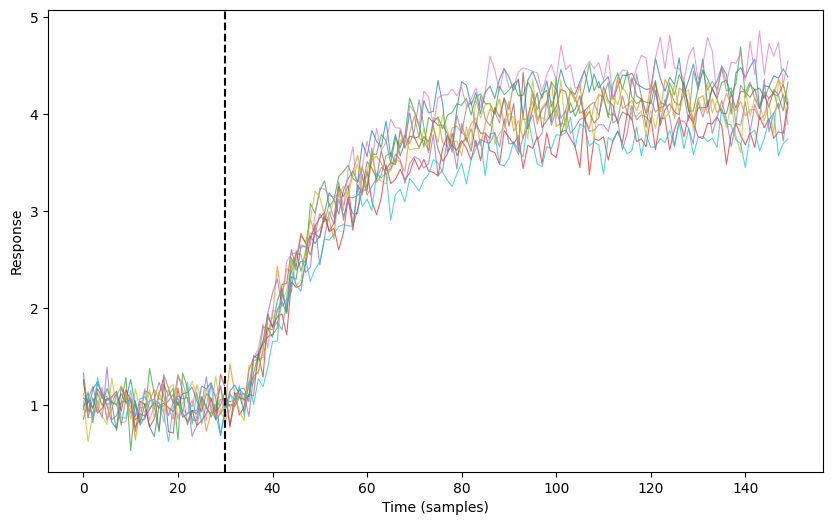

In [6]:
import numpy as np

# Parameters for fake data
n_trials = 10
n_samples = 150
step_onset = 30  # sample idx when step occurs
K_true = 3.0     # true response gain
tau_true = 18.0  # time constant (samples)
L_true = 4.0     # dead time (delay in samples)
y0_true = 1.0    # baseline offset

# Step input signal
u_on = np.zeros(n_samples, dtype=bool)
u_on[step_onset:] = True

# Time base for each sample (assuming dt = 1 sample/unit)
t = np.arange(n_samples)

# Generate fake response for each trial (add noise)
y = np.zeros((n_trials, n_samples))
for k in range(n_trials):
    # replicate: y0 + K * (1 - exp(-(t - (step_onset+L_true))/tau_true)), with time >= step_onset+L_true
    # some random noise per trial & randomize gain/tau for small biological variability
    dK = np.random.normal(0, 0.2)
    dtau = np.random.normal(0, 1.0)
    K = K_true + dK
    tau = tau_true + dtau
    L = L_true + int(np.random.uniform(-1, 1))
    t_effective = np.maximum(0, t - (step_onset + L))
    response = y0_true + K * (1.0 - np.exp(-t_effective / tau))
    # Add noise
    noise = np.random.normal(0, 0.15, size=n_samples)
    y[k, :] = response + noise

# Plot fake data
plt.figure(figsize=(10, 6))
for k in range(n_trials):
    plt.plot(t, y[k, :], lw=0.8, alpha=0.7)
plt.axvline(step_onset, color='k', linestyle='--', lw=1.5)
plt.xlabel('Time (samples)')
plt.ylabel('Response')

print(u_on)

In [45]:
import numpy as np
from scipy.optimize import least_squares

# ---- utilities reused -------------------------------------------------------
def _find_step_segment(u_on):
    """
    Locate the indices for the beginning and end of a step, and return the step amplitude.
    Parameters:
      u_on: array-like boolean or int (input ON/OFF over time)
    Returns:
      step_start_idx, step_end_idx, step_size
    """
    u = np.asarray(u_on, int)  # Convert to integer array
    change_indices = np.flatnonzero(np.diff(u) != 0)  # Indices of all state changes
    if change_indices.size == 0: 
        raise ValueError("No ON/OFF transition in u_on.")
    step_start_idx = change_indices[0]      # first transition: step starts
    # If there is a second change, step ends there, otherwise at end of u
    step_end_idx = (change_indices[1]+1) if change_indices.size > 1 else len(u)
    step_size = u[step_start_idx+1] - u[step_start_idx]  # +1 for ON, -1 for OFF
    return step_start_idx, step_end_idx, int(step_size)

def _fopdt_step(time, gain, tau, delay, baseline, step_size, step_start_time):
    """
    Standard First Order Plus Dead Time (FOPDT) step response.
    """
    time_effective = np.maximum(0.0, time - (step_start_time + delay))  # time after both step onset and delay
    return baseline + gain*step_size*(1.0 - np.exp(-time_effective/np.maximum(tau, 1e-9)))

def _sopdt_step(time, gain, wn, zeta, delay, baseline, step_size, step_start_time):
    """
    Standard Second Order Plus Dead Time (SOPDT) step response.
    """
    time_effective = np.maximum(0.0, time - (step_start_time + delay))
    wn = np.maximum(wn, 1e-9)    # natural frequency
    zeta = np.maximum(zeta, 1e-6) # damping ratio
    response = np.empty_like(time, float)
    # Underdamped case (oscillatory)
    if zeta < 1:
        wd = wn*np.sqrt(1 - zeta**2)  # damped natural frequency
        envelope = np.exp(-zeta*wn*time_effective)
        response[:] = baseline + gain*step_size*(1 - envelope*(np.cos(wd*time_effective) + (zeta/np.sqrt(1-zeta**2))*np.sin(wd*time_effective)))
    # Critically damped case
    elif np.isclose(zeta, 1.0, atol=1e-3):
        response[:] = baseline + gain*step_size*(1 - np.exp(-wn*time_effective)*(1 + wn*time_effective))
    # Overdamped case
    else:
        s1 = -wn*(zeta - np.sqrt(zeta**2 - 1))
        s2 = -wn*(zeta + np.sqrt(zeta**2 - 1))
        numerator = (s2*np.exp(s1*time_effective) - s1*np.exp(s2*time_effective))
        denominator = (s2 - s1)
        response[:] = baseline + gain*step_size*(1 - numerator/denominator)
    return response

def _metrics(y, yhat, param_count):
    """
    Compute model fit metrics: RMSE, R2, VAF, AIC, BIC.
    """
    y = np.asarray(y)
    yhat = np.asarray(yhat)
    n_points = y.size
    rss = np.sum((y - yhat)**2)  # residual sum of squares
    tss = np.sum((y - y.mean())**2) + 1e-12  # total sum of squares
    rmse = np.sqrt(rss/n_points)
    r2 = 1 - rss/tss
    vaf = 100*(1 - np.var(y - yhat)/np.var(y) if np.var(y)>0 else 0.0)  # Variance Accounted For (%)
    sigma2 = rss/n_points  # variance of residuals
    aic = 2*param_count + n_points*np.log(sigma2 + 1e-12)     # Akaike Information Criterion
    bic = param_count*np.log(n_points) + n_points*np.log(sigma2 + 1e-12)  # Bayesian Information Criterion
    return dict(RMSE=rmse, R2=r2, VAF=vaf, AIC=aic, BIC=bic)

# ---- GLOBAL FOPDT: shared gain, tau, delay; individual baseline per trial ----
def fit_fopdt(y, u_on, Fs=10000, pre_s=1.0):
    """
    Fit a First-Order Plus Dead Time model with shared K/tau/L, and per-trial baseline.
    Args:
        y: shape (n_trials, n_samples) or (n_samples,)
        u_on: input ON array
        Fs: sampling rate [Hz]
        pre_s: window (s) for baseline estimation prior to step
    Returns:
        Fit and metrics dictionary.
    """
    dt = 1.0 / Fs
    Y = np.asarray(y, float)
    if Y.ndim == 1: 
        Y = Y[None, :]  # Ensure 2D array
    n_trials, n_samples = Y.shape
    time_axis = np.arange(n_samples)*dt  # x axis (seconds)
    step_start_idx, step_end_idx, step_size = _find_step_segment(u_on)
    step_start_time = (step_start_idx+1)*dt
    baseline_window = max(1, int(round(pre_s/dt)))
    # Estimate per-trial baseline y0s as median before step
    y0_trials = np.array([np.median(Y[i, max(0,step_start_idx-baseline_window):step_start_idx]) 
                          for i in range(n_trials)], float)
    # Heuristic initials using trial-averaged data
    y_mean = Y.mean(axis=0)
    y0_mean = float(np.median(y_mean[max(0,step_start_idx-baseline_window):step_start_idx]))
    y_end_mean = float(np.median(y_mean[max(step_start_idx+1, step_end_idx-baseline_window):step_end_idx]))
    delta_y = (y_end_mean - y0_mean)
    gain_init = delta_y/max(step_size,1e-9)
    # Use 63% rule (1 - exp(-1)) for initial tau, tangent for L (simple heuristics)
    target_level = y0_mean + 0.632*delta_y
    after_step = np.arange(n_samples) >= (step_start_idx+1)
    crossing_point = np.flatnonzero(after_step & ((y_mean - target_level)*(np.sign(delta_y) if delta_y!=0 else 1) >= 0))
    tau_init = ((crossing_point[0]-(step_start_idx+1))*dt) if crossing_point.size else 0.25*((step_end_idx-1)-(step_start_idx+1))*dt
    delay_init = 0.0

    # parameter vector: [gain, tau, delay, y0_trial_1, ..., y0_trial_n]
    x0 = np.r_[gain_init, max(tau_init, dt), max(delay_init, 0.0), y0_trials]
    lb = np.r_[-1e6, 1e-6, 0.0, y0_trials - 5*abs(delta_y+1e-6)]  # lower bounds
    ub = np.r_[ 1e6, 1e6, (time_axis[step_end_idx-1]-step_start_time), y0_trials + 5*abs(delta_y+1e-6)]  # upper

    def resid(param_vec):
        gain, tau, delay = param_vec[0], param_vec[1], param_vec[2]
        baseline_trials = param_vec[3:]
        resids = []
        for trial_idx in range(n_trials):
            yhat = _fopdt_step(time_axis, gain, tau, delay, baseline_trials[trial_idx], step_size, step_start_time)
            # Only fit response region after step.
            resids.append(Y[trial_idx, step_start_idx+1:step_end_idx] - yhat[step_start_idx+1:step_end_idx])
        return np.concatenate(resids)

    # Fit using least squares
    sol = least_squares(resid, x0, bounds=(lb, ub), max_nfev=40000)
    gain, tau, delay = sol.x[0], sol.x[1], sol.x[2]
    baseline_trials_fitted = sol.x[3:]
    # predictions (mean-of-preds for plotting)
    yhat_trials = np.vstack([_fopdt_step(time_axis, gain, tau, delay, baseline_trials_fitted[i], step_size, step_start_time) 
                             for i in range(n_trials)])
    yhat_mean = yhat_trials.mean(axis=0)
    return {"params": {"K":gain,"tau":tau,"L":delay,"y0_per_trial":baseline_trials_fitted,"du":step_size,"t0":step_start_time},
            "yhat_mean": yhat_mean, "yhat_trials": yhat_trials,
            "metrics": _metrics(y, yhat_mean, param_count=3+len(baseline_trials_fitted))}

# ---- GLOBAL SOPDT: shared K,wn,zeta,delay; per-trial baseline ---------------
def fit_sopdt(y, u_on, Fs=10000, pre_s=1.0):
    """
    Fit a Second-Order Plus Dead Time model with shared K, wn, zeta, L and per-trial baseline.
    Args:
        y: shape (n_trials, n_samples) or (n_samples,)
        u_on: input ON array
        Fs: sampling rate [Hz]
        pre_s: window (s) for baseline estimation prior to step
    Returns:
        Fit and metrics dictionary.
    """
    dt = 1.0 / Fs
    Y = np.asarray(y, float)
    if Y.ndim == 1: 
        Y = Y[None, :]
    n_trials, n_samples = Y.shape
    time_axis = np.arange(n_samples)*dt
    step_start_idx, step_end_idx, step_size = _find_step_segment(u_on)
    step_start_time = (step_start_idx+1)*dt
    baseline_window = max(1, int(round(pre_s/dt)))
    y0_trials = np.array([np.median(Y[i, max(0,step_start_idx-baseline_window):step_start_idx]) 
                          for i in range(n_trials)], float)
    y_mean = Y.mean(axis=0)
    y0_mean = float(np.median(y_mean[max(0,step_start_idx-baseline_window):step_start_idx]))
    y_end_mean = float(np.median(y_mean[max(step_start_idx+1,step_end_idx-baseline_window):step_end_idx]))
    delta_y = (y_end_mean - y0_mean)
    gain_init = delta_y/max(step_size,1e-9)
    env_tau_init = max(dt, 0.25*((step_end_idx-1)-(step_start_idx+1))*dt)
    zeta_init = 0.7
    wn_init = 1.0/max(zeta_init*env_tau_init, dt)  # initial natural frequency
    delay_init = 0.0

    # parameter vector: [K, wn, zeta, delay, y0_1, ...]
    x0 = np.r_[gain_init, wn_init, zeta_init, delay_init, y0_trials]
    lb = np.r_[-1e6, 1e-6, 1e-3, 0.0, y0_trials - 5*abs(delta_y+1e-6)]
    ub = np.r_[ 1e6, 1e3,  10.0, (time_axis[step_end_idx-1]-step_start_time), y0_trials + 5*abs(delta_y+1e-6)]

    def resid(param_vec):
        gain, wn, zeta, delay = param_vec[0], param_vec[1], param_vec[2], param_vec[3]
        baseline_trials = param_vec[4:]
        resids = []
        for trial_idx in range(n_trials):
            yhat = _sopdt_step(time_axis, gain, wn, zeta, delay, baseline_trials[trial_idx], step_size, step_start_time)
            resids.append(Y[trial_idx, step_start_idx+1:step_end_idx] - yhat[step_start_idx+1:step_end_idx])
        return np.concatenate(resids)

    sol = least_squares(resid, x0, bounds=(lb, ub), max_nfev=60000)
    gain, wn, zeta, delay = sol.x[0], sol.x[1], sol.x[2], sol.x[3]
    baseline_trials_fitted = sol.x[4:]
    yhat_trials = np.vstack([
        _sopdt_step(time_axis, gain, wn, zeta, delay, baseline_trials_fitted[i], step_size, step_start_time) 
        for i in range(n_trials)])
    yhat_mean = yhat_trials.mean(axis=0)
    return {"params": {"K":gain,"wn":wn,"zeta":zeta,"L":delay,"y0_per_trial":baseline_trials_fitted,"du":step_size,"t0":step_start_time},
            "yhat_mean": yhat_mean, "yhat_trials": yhat_trials,
            "metrics": _metrics(y, yhat_mean, param_count=4+len(baseline_trials_fitted))}


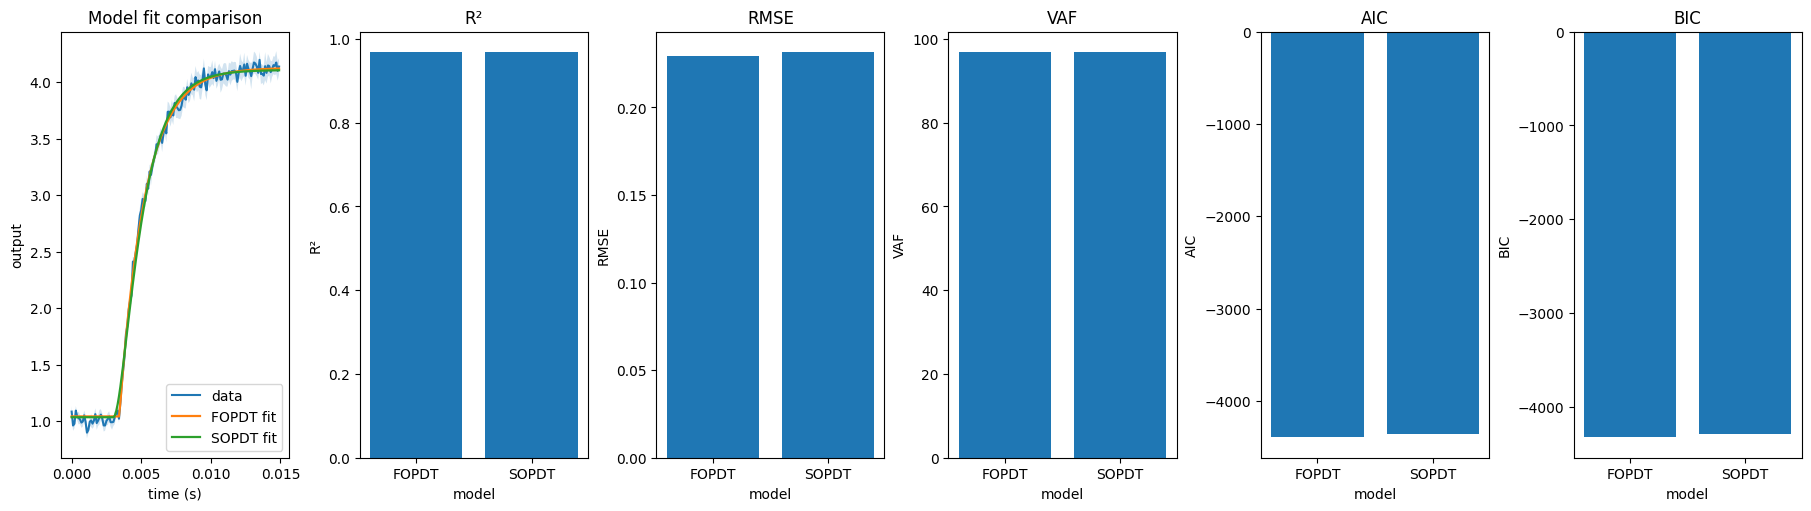

In [46]:
def fit_and_plot_compare(y, u_on, Fs=10000):
    dt = 1.0 / Fs
    y = np.asarray(y, float); t = np.arange(y.shape[1])*dt
    f1 = fit_fopdt(y, u_on, Fs=Fs)
    f2 = fit_sopdt(y, u_on, Fs=Fs)

    # Plot fitted trace and bar plots of all metrics, each in a separate subplot
    metrics = [f1["metrics"], f2["metrics"]]
    labels = ["FOPDT", "SOPDT"]
    metric_keys = ["R2", "RMSE", "VAF", "AIC", "BIC"]
    metric_pretty_names = {
        "R2": "R²",
        "RMSE": "RMSE",
        "VAF": "VAF",
        "AIC": "AIC",
        "BIC": "BIC"
    }
    n_metrics = len(metric_keys)
    fig, axes = plt.subplots(1, 1+n_metrics, figsize=(3*(1+n_metrics),5), constrained_layout=True)

    # First subplot: fit traces
    plot_sem(y, t, label="data", ax=axes[0])
    axes[0].plot(t, f1["yhat_mean"], lw=1.6, label="FOPDT fit")
    axes[0].plot(t, f2["yhat_mean"], lw=1.6, label="SOPDT fit")
    axes[0].set_xlabel("time (s)"); 
    axes[0].set_ylabel("output"); 
    axes[0].set_title("Model fit comparison"); 
    axes[0].legend()

    # Next subplots: each metric bar plot
    for i, mkey in enumerate(metric_keys):
        axes[i+1].bar(labels, [m[mkey] for m in metrics])
        axes[i+1].set_xlabel("model")
        axes[i+1].set_ylabel(metric_pretty_names.get(mkey, mkey))
        axes[i+1].set_title(f"{metric_pretty_names.get(mkey, mkey)}")

    return f1, f2

# R2: lower is better
# RMSE: lower is better
# VAF: higher is better
# AIC: lower is better
# BIC: lower is better
f1, f2 = fit_and_plot_compare(y, u_on)

In [ ]:
import math
from typing import Dict, Optional

def _sopdt_tau12_from_wn_zeta(wn: float, zeta: float):
    """
    Given wn (natural frequency) and zeta (damping ratio),
    calculate tau1 and tau2 for a SOPDT model.

    Solves:
        tau1 + tau2 = 2*zeta/wn
        tau1 * tau2 = 1/wn**2
    """
    S = 2.0 * zeta / wn
    P = 1.0 / (wn ** 2)
    discriminant = max(S ** 2 - 4.0 * P, 0.0)
    t1 = 0.5 * (S + math.sqrt(discriminant))
    t2 = 0.5 * (S - math.sqrt(discriminant))

    # Enforce tau1 >= tau2 > 0
    tau1, tau2 = max(t1, t2), min(t1, t2)
    if tau2 <= 0:
        # If numerical issue, fall back to equal times
        tau1 = tau2 = S / 2.0
    return tau1, tau2

def _series_to_ideal(Kc: float, Ti: float, Td: float):
    """
    Map series PID form to ideal (parallel) PID form as per Skogestad (Eq 5.30).

    Args:
        Kc: Proportional gain (series form)
        Ti: Integral time (series form)
        Td: Derivative time (series form)

    Returns:
        Tuple (Kp, Ti, Td) in parallel (ideal) form.
    """
    if Td <= 0 or Ti <= 0:
        return Kc, Ti, 0.0
    factor = 1.0 + Td / Ti
    return Kc * factor, Ti * factor, Td / factor

def tune_pid(
    params: Dict[str, float],
    method: str = "SIMC",                # PID tuning method: "SIMC" or "ZN_open"
    form: str = "parallel",              # Controller form; "parallel" gives Kp, Ki, Kd
    tau_c: Optional[float] = None,       # Desired closed-loop time constant; defaults to theta
    improved_pi: bool = True,            # SIMC improvement: tau1 -> tau1 + theta/3 for PI
    derivative_filter_N: float = 10.0    # Derivative filter parameter N
) -> Dict[str, float]:
    k = float(params["K"])
    theta = float(params.get("L", 0.0))

    # Get model time constants
    tau1 = params.get("tau", None) or params.get("tau1", None)
    tau2 = params.get("tau2", None)

    # If given wn and zeta, convert to tau1/tau2
    if "wn" in params and "zeta" in params:
        tau1, tau2 = _sopdt_tau12_from_wn_zeta(float(params["wn"]), float(params["zeta"]))

    tauc = float(tau_c) if tau_c is not None else float(theta)

    if method.upper() == "SIMC":
        # SIMC: FOPDT yields a PI controller; SOPDT yields a PID
        if tau2 is None:
            # FOPDT: PI controller
            t1_eff = float(tau1)
            if improved_pi:
                t1_eff = float(tau1) + theta / 3.0

            Kc_series = (t1_eff / (tauc + theta)) / k
            Ti_series = min(t1_eff, 4.0 * (tauc + theta))
            Td_series = 0.0
        else:
            # SOPDT: PID controller (series form)
            Kc_series = (tau1 / (tauc + theta)) / k
            Ti_series = min(tau1, 4.0 * (tauc + theta))
            Td_series = float(tau2)

        # Convert to ideal (parallel) form
        Kp_ideal, Ti_ideal, Td_ideal = _series_to_ideal(Kc_series, Ti_series, Td_series)
        Kp = Kp_ideal
        Ki = (Kp / Ti_ideal) if Ti_ideal > 0 else 0.0
        Kd = Kp * Td_ideal

        return {
            "method": "SIMC",
            "Kp": Kp,
            "Ki": Ki,
            "Kd": Kd,
            "Ti": Ti_ideal,
            "Td": Td_ideal,
            "tau_c": tauc,
            "N": derivative_filter_N
        }

    elif method.upper() == "ZN_OPEN":
        # Ziegler–Nichols reaction curve method for FOPDT
        if tau1 is None or theta <= 0:
            raise ValueError(
                "ZN_open requires FOPDT with tau (tau1) and positive dead time L=theta."
            )
        Kp = 1.2 * (tau1 / (k * theta))
        Ti = 2.0 * theta
        Td = 0.5 * theta
        Ki = Kp / Ti
        Kd = Kp * Td
        return {
            "method": "ZN_open",
            "Kp": Kp,
            "Ki": Ki,
            "Kd": Kd,
            "Ti": Ti,
            "Td": Td,
            "N": derivative_filter_N
        }
    else:
        raise ValueError("Unknown method. Use 'SIMC' or 'ZN_open'.")


In [ ]:
# FOPDT example
params_fopdt = {"K": 0.85, "tau": 1.3, "L": 0.25}
gains_pi = tune_pid(params_fopdt, method="SIMC")  # returns PI (Kd=0)

# SOPDT example (you supplied wn, zeta)
params_sopdt = {"K": 1.1, "wn": 8.0, "zeta": 0.6, "L": 0.08}
gains_pid = tune_pid(params_sopdt, method="SIMC")  # returns full PID

# Ziegler–Nichols open-loop (FOPDT only)
gains_zn = tune_pid(params_fopdt, method="ZN_open")

# Section 4: Overlay analysis

# Section 5: Manual overlay analysis
